# Preparación de datos
## Importar bibliotecas

In [1]:
import pandas as pd 
import numpy as np 
import scipy as sp
import math
import re
from tqdm import tqdm
import json
import gzip
from datetime import datetime

import matplotlib.pyplot as plt
from unidecode import unidecode
import seaborn as sns


from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, BooleanType
from pyspark.sql.functions import from_json, col
from pyspark.sql.functions import explode
from pyspark.sql.functions import udf
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import regexp_replace, to_date, trim, when, expr, concat, lit, col
from pyspark.sql.types import StringType, DateType

# Importar funciones necesarias
from pyspark.sql.functions import col, to_date, weekofyear,year, month, dayofmonth, sum
from pyspark.sql.functions import count, coalesce, sum as spark_sum
from pyspark.sql.functions import regexp_replace, col, when, explode_outer,lit, to_timestamp,regexp_extract,lower,split
from pyspark.sql.functions import format_number
from pyspark.sql.types import IntegerType,FloatType
# Puedes obtener estadísticas específicas para una columna
from pyspark.sql.functions import mean, min, max
from pyspark.sql.functions import approx_count_distinct
from pyspark.sql.window import Window
from pyspark.sql.functions import log1p
from pyspark.sql import functions as F

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *

## Importación de Datos

In [2]:

spark = SparkSession.builder.appName("MLops_Steam_etl").getOrCreate()
"""
spark = SparkSession.builder \
    .appName("MLops_Steam_etl") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

"""

'\nspark = SparkSession.builder     .appName("MLops_Steam_etl")     .config("spark.executor.heartbeatInterval", "60s")     .config("spark.network.timeout", "600s")     .getOrCreate()\n\n'

In [3]:
#SparkSession.builder.appName("MLops_Steam_etl").getOrCreate().stop()


In [4]:
spark

In [5]:
# Leer el archivo Parquet
steam_games = spark.read.parquet("../datasets/raw/steam_games_parquet")
user_reviews = spark.read.parquet("../datasets/raw/user_reviews_parquet")
users_items = spark.read.parquet("../datasets/raw/users_items_parquet")

In [6]:
print("Cantidad de registros :", steam_games.count(), "Cantidad de las Columnas :", len(steam_games.columns))
print("Cantidad de registros :", user_reviews.count(), "Cantidad de las Columnas :", len(user_reviews.columns))
print("Cantidad de registros :", users_items.count(), "Cantidad de las Columnas :", len(users_items.columns))

Cantidad de registros : 120445 Cantidad de las Columnas : 13
Cantidad de registros : 59305 Cantidad de las Columnas : 9
Cantidad de registros : 5153209 Cantidad de las Columnas : 8


## Preprocesamiento de Datos

In [7]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import StringType

# Definir la función para limpiar y formatear los nombres de las columnas
def limpiar_nombres_columnas(df):
    def limpiar_nombre(nombre):
        nombre = re.sub(r'\W+', '_', nombre)
        nombre = unidecode(nombre)
        nombre = nombre.lower()
        return nombre
    
    nuevos_nombres = [limpiar_nombre(col) for col in df.columns]
    
    for viejo, nuevo in zip(df.columns, nuevos_nombres):
        df = df.withColumnRenamed(viejo, nuevo)
    
    return df

# Definir la función para tratar filas con valores nulos o vacíos
def t_filas_nulos(df, columnas_a_eliminar=None, columna_filtro=None, eliminar_filas_vacias=False):
    # Eliminar columnas si se proporcionan
    if columnas_a_eliminar:
        df = df.drop(*columnas_a_eliminar)
    
    # Filtrar registros nulos o vacíos en la columna especificada, si se proporciona
    if columna_filtro and eliminar_filas_vacias:
        df = df.filter(col(columna_filtro).isNotNull() & (col(columna_filtro) != ""))
    
    return df

# Volver a aplicar la función de limpieza de nombres de columnas
steam_games = limpiar_nombres_columnas(steam_games)
user_reviews = limpiar_nombres_columnas(user_reviews)
users_items = limpiar_nombres_columnas(users_items)

# game_id debería ser la columna filtro y los nulos deberían clasificarse como "Unknown"
steam_games = t_filas_nulos(steam_games, columnas_a_eliminar=["publisher", "title", "url", "tags_str", "reviews_url", "specs_str", "early_access"], columna_filtro="game_id", eliminar_filas_vacias=True)
user_reviews = t_filas_nulos(user_reviews, columnas_a_eliminar=["user_url", "last_edited", "funny", "helpful"], columna_filtro="item_id", eliminar_filas_vacias=True)
users_items = t_filas_nulos(users_items, columnas_a_eliminar=["user_url", "user_id"], columna_filtro="steam_id", eliminar_filas_vacias=True)



In [8]:
steam_games = steam_games.withColumn(
    "price",
    when(steam_games["price"].isin("", "Free", "Free Demo", "Free HITMAN™ Holiday Pack", "Free Mod", "Free Movie", "Free To Play", "Free to Play", "Free to Try", "Free to Use", "Install Now", "Install Theme", "Play Now", "Play WARMACHINE: Tactics Demo", "Play for Free!", "Play the Demo", "Third-party"), -1.0)
    .otherwise(regexp_extract(steam_games["price"], r'\d+(\.\d+)?', 0).cast("float"))
)

# Tratar los valores en la columna 'release_date'
steam_games_transformed = steam_games.withColumn(
    "release_date",
    when(
        (steam_games["release_date"] == "") | 
        (steam_games["release_date"] == '"""Soon"""') | 
        (steam_games["release_date"].rlike('[^\d-]')), 
        '1970-01-01'
    )
    .otherwise(steam_games["release_date"])
)


# Extraer los años de la columna 'release_date' y crear la columna 'year'
steam_games_transformed = steam_games_transformed.withColumn(
    "year",
    when(
        (steam_games_transformed["release_date"] != "") & (steam_games_transformed["release_date"].rlike(r"(\d{4})")),
        regexp_extract(steam_games_transformed["release_date"], r"(\d{4})", 1).cast(IntegerType())
    )
    .otherwise(
        when(
            (steam_games_transformed["release_date"].like("%soon%") | steam_games_transformed["release_date"].like("%Soon%")),
            "TBD"
        )
        .otherwise("Unknown")
    )
)


# Convertir la columna 'year' a tipo entero
steam_games_transformed = steam_games_transformed.withColumn("year", when(steam_games_transformed["year"] != "TBD", steam_games_transformed["year"].cast(IntegerType())).otherwise(-1))

# Convertir la columna 'release_date' a tipo fecha
steam_games_transformed = steam_games_transformed.withColumn("release_date", col("release_date").cast(DateType()))
# 1. Usa explode para convertir la lista en filas adicionales
df_exploded = steam_games_transformed.select("genres_str", explode(split("genres_str", ",")).alias("genre"))

# 2. Puedes realizar más transformaciones si es necesario
# Por ejemplo, si quieres agregar alguna lógica específica o limpieza de datos
# Puedes realizar operaciones como trim, regexp_replace, etc.
df_exploded = df_exploded.withColumn("genre", lower(regexp_replace(trim(col("genre")), "[^a-zA-Z0-9_]", "")))

# 3. Reemplazar cadenas vacías en la columna 'genre' por 'Unknown'
df_exploded = df_exploded.withColumn("genre", when(col("genre") == "", "Unknown").otherwise(col("genre")))

# 4. Actualizar los valores en la tabla steam_games_transformed
steam_games_transformed = steam_games_transformed.join(df_exploded, on="genres_str")
steam_games_transformed = steam_games_transformed.withColumn("genres_str", col("genre")).drop("genre")
# Tratar la columna 'developer'
steam_games_transformed = steam_games_transformed.withColumn("developer", when(steam_games_transformed["developer"].isNull() | (steam_games_transformed["developer"] == ""), "Unknown").otherwise(steam_games_transformed["developer"]))
steam_games_transformed = steam_games_transformed.withColumn("app_name", when(col("app_name").isin("", "null", "NULL", "Null", "nil", "NaN", "NA"), "Unknown").otherwise(col("app_name")))
steam_games_transformed = steam_games_transformed.dropDuplicates(['app_name', 'release_date', 'price', 'game_id', 'developer', 'year'])

In [9]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [10]:
# Función para tratar la columna 'recommend'
def transform_recommend_column(df):
    df_transformed = df.withColumn(
        "recommend",
        when(df["recommend"] == True, 1)
        .otherwise(when(df["recommend"] == False, 0))
    ).withColumn("recommend", col("recommend").cast(IntegerType()))  # Convertir a tipo entero
    return df_transformed
user_reviews_transformed = transform_recommend_column(user_reviews)


In [11]:
# Obtén el año actual
current_year = datetime.now().year

# Define el formato de fecha que parece tener el campo 'posted'
date_format = 'MMM d, yyyy.'

# Limpia y estandariza el campo 'posted' utilizando expresiones regulares
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_posted",
    regexp_replace("posted", r'Posted\s*', '')  # Elimina 'Posted'
)

# Elimina espacios en blanco adicionales
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_posted",
    trim(user_reviews_transformed["clean_posted"]).alias("clean_posted")
)

# Agrega el año actual a las fechas que no tienen año
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_posted",
    when(user_reviews_transformed["clean_posted"].contains(","), user_reviews_transformed["clean_posted"]).otherwise(expr('concat(clean_posted, ", {}")'.format(current_year)))
)

# Elimina el punto intermedio y agrega un punto al final
user_reviews_transformed = user_reviews_transformed.withColumn(
    "clean_date",
    trim(concat(regexp_replace("clean_posted", r'\.,', ','), lit('.')))
)

# Convierte el campo 'clean_date' a formato de fecha utilizando to_date
user_reviews_transformed = user_reviews_transformed.withColumn(
    "posted_date",
    to_date("clean_date", date_format).cast(DateType()).alias("posted_date")
)

# Reemplaza las cadenas nulas o vacías en la columna 'review' con 'Unknown'
user_reviews_transformed = user_reviews_transformed.withColumn("review", when((col("review").isNull()) | (col("review") == ""), "Unknown").otherwise(col("review")))

# Muestra el DataFrame resultante
#user_reviews_transformed.show(truncate=False)
# Eliminar las columnas mencionadas
user_reviews_transformed = user_reviews_transformed.drop("posted", "clean_posted", "clean_date")

In [12]:
user_reviews_transformed.show(10)

+-------------------+-------+---------+--------------------+-----------+
|            user_id|item_id|recommend|              review|posted_date|
+-------------------+-------+---------+--------------------+-----------+
|kitchenappliancewow| 322330|        1|Don't Starve Toge...| 2024-08-19|
|kitchenappliancewow| 413150|        1|Stardew Valley is...| 2024-08-19|
|  kittenwithmittens| 287290|        0|Cooperative play ...| 2015-02-25|
|  76561198068660878| 301520|        1|                good| 2024-08-23|
|  76561198068660878|    620|        1|  sooooooo gooooood!| 2024-08-13|
|  76561198068660878| 212680|        1|  This game is great| 2015-11-09|
|  76561198068660878| 218230|        1|           good game| 2014-10-14|
|  76561198065171294|   4000|        1|                 ...| 2024-02-12|
|  76561198068160202|    440|        1|             10 star| 2014-02-27|
|       coronelcross| 312990|        1|super entretenido...| 2014-08-21|
+-------------------+-------+---------+------------

In [13]:


# Convierte la columna 'items_count' a entero
users_items_transformed = users_items.withColumn("items_count", col("items_count").cast("int"))

# Convierte la columna 'playtime_forever' a entero
users_items_transformed = users_items_transformed.withColumn("playtime_forever", col("playtime_forever").cast("int"))

# Convierte la columna 'playtime_2weeks' a entero
users_items_transformed = users_items_transformed.withColumn("playtime_2weeks", col("playtime_2weeks").cast("int"))

users_items_transformed = users_items_transformed.dropDuplicates(['item_id'])
#user_reviews_transformed = t_filas_nulos(user_reviews_transformed, columnas_a_eliminar=["user_url"], eliminar_filas_vacias=False)

In [14]:
# Define the function to count null or empty values for each column
def count_null_values(df):
    return df.select(
        *[sum(coalesce(col(c) == "", col(c).isNull()).cast("int")).alias(c) for c in df.columns]
    )

# Clean and count null values for each DataFrame
#steam_games = limpiar_nombres_columnas(steam_games)
valores_vacios_por_columna_steam = count_null_values(steam_games_transformed)
valores_vacios_por_columna_steam.show()

#user_reviews = limpiar_nombres_columnas(user_reviews)
valores_vacios_por_columna_reviews = count_null_values(user_reviews_transformed)
valores_vacios_por_columna_reviews.show()

#users_items = limpiar_nombres_columnas(users_items)
valores_vacios_por_columna_items = count_null_values(users_items_transformed)
valores_vacios_por_columna_items.show()

+----------+--------+------------+-----+-------+---------+----+
|genres_str|app_name|release_date|price|game_id|developer|year|
+----------+--------+------------+-----+-------+---------+----+
|         0|       0|           0|    0|      0|        0|   0|
+----------+--------+------------+-----+-------+---------+----+

+-------+-------+---------+------+-----------+
|user_id|item_id|recommend|review|posted_date|
+-------+-------+---------+------+-----------+
|      0|      0|        0|     0|          0|
+-------+-------+---------+------+-----------+

+-----------+--------+-------+---------+----------------+---------------+
|items_count|steam_id|item_id|item_name|playtime_forever|playtime_2weeks|
+-----------+--------+-------+---------+----------------+---------------+
|          0|       0|      0|        0|               0|              0|
+-----------+--------+-------+---------+----------------+---------------+



In [15]:
steam_games_transformed
user_reviews_transformed
users_items_transformed
steam_games_transformed.game_id
user_reviews_transformed.item_id
users_items_transformed.item_id


Column<'item_id'>

In [16]:
print("Cantidad de registros :", steam_games_transformed.count(), "Cantidad de las Columnas :", len(steam_games_transformed.columns))
print("Cantidad de registros :", user_reviews_transformed.count(), "Cantidad de las Columnas :", len(user_reviews_transformed.columns))
print("Cantidad de registros :", users_items_transformed.count(), "Cantidad de las Columnas :", len(users_items_transformed.columns))

Cantidad de registros : 32132 Cantidad de las Columnas : 7
Cantidad de registros : 59305 Cantidad de las Columnas : 5
Cantidad de registros : 10978 Cantidad de las Columnas : 6


In [17]:
"""
ruta_destino_parquet_i = '../datasets/processed/user_reviews_parquet'
steam_games_transformed.write.mode("overwrite").parquet(ruta_destino_parquet_i)
ruta_destino_parquet_ii = '../datasets/processed/users_items_parquet'
user_reviews_transformed.write.mode("overwrite").parquet(ruta_destino_parquet_ii)

ruta_destino_parquet_iii = '../datasets/processed/steam_games_parquet'
users_items_transformed.write.mode("overwrite").parquet(ruta_destino_parquet_iii)
"""

'\nruta_destino_parquet_i = \'../datasets/processed/user_reviews_parquet\'\nsteam_games_transformed.write.mode("overwrite").parquet(ruta_destino_parquet_i)\nruta_destino_parquet_ii = \'../datasets/processed/users_items_parquet\'\nuser_reviews_transformed.write.mode("overwrite").parquet(ruta_destino_parquet_ii)\n\nruta_destino_parquet_iii = \'../datasets/processed/steam_games_parquet\'\nusers_items_transformed.write.mode("overwrite").parquet(ruta_destino_parquet_iii)\n'

In [18]:
# Unir steam_games_transformed con user_reviews_transformed
joined_df = steam_games_transformed.join(user_reviews_transformed, steam_games_transformed.game_id == user_reviews_transformed.item_id, "inner")

# Unir el resultado anterior con users_items_transformed usando item_id
final_etl = joined_df.join(users_items_transformed, joined_df.item_id == users_items_transformed.item_id, "inner")

# Seleccionar las columnas relevantes después de la unión
final_etl = final_etl.select(
    steam_games_transformed["genres_str"],
    steam_games_transformed["app_name"],
    steam_games_transformed["release_date"],
    steam_games_transformed["price"],
    steam_games_transformed["game_id"],
    steam_games_transformed["developer"],
    steam_games_transformed["year"],
    user_reviews_transformed["user_id"],
    user_reviews_transformed["item_id"].alias("user_reviews_item_id"),
    user_reviews_transformed["recommend"],
    user_reviews_transformed["review"],
    user_reviews_transformed["posted_date"],
    users_items_transformed["items_count"],
    users_items_transformed["steam_id"],
    users_items_transformed["item_id"].alias("users_items_item_id"),
    users_items_transformed["item_name"],
    users_items_transformed["playtime_forever"],
    users_items_transformed["playtime_2weeks"]
    # Agrega otras columnas que desees incluir en el resultado
)

In [19]:
final_etl.show(5)

+----------+--------------+------------+-----------------+-------+---------+----+-----------------+--------------------+---------+--------------------+-----------+-----------+-----------------+-------------------+--------------+----------------+---------------+
|genres_str|      app_name|release_date|            price|game_id|developer|year|          user_id|user_reviews_item_id|recommend|              review|posted_date|items_count|         steam_id|users_items_item_id|     item_name|playtime_forever|playtime_2weeks|
+----------+--------------+------------+-----------------+-------+---------+----+-----------------+--------------------+---------+--------------------+-----------+-----------+-----------------+-------------------+--------------+----------------+---------------+
|    action|Counter-Strike|  2000-11-01|9.989999771118164|     10|    Valve|2000|             mizi|                  10|        1|        og cs is god| 2015-05-23|         11|76561197971591953|                 10|C

In [20]:
final_etl.printSchema()

root
 |-- genres_str: string (nullable = false)
 |-- app_name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- price: double (nullable = true)
 |-- game_id: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_reviews_item_id: string (nullable = true)
 |-- recommend: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- posted_date: date (nullable = true)
 |-- items_count: integer (nullable = true)
 |-- steam_id: string (nullable = true)
 |-- users_items_item_id: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- playtime_forever: integer (nullable = true)
 |-- playtime_2weeks: integer (nullable = true)



In [22]:
#final_etl = spark.read.csv("../datasets/processed/dataset.csv", header=True, inferSchema=True)

In [23]:
# estas son las clases para sustitutición con sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from sklearn.preprocessing import FunctionTransformer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ozi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
df = final_etl.toPandas()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47675 entries, 0 to 47674
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres_str            47675 non-null  object 
 1   app_name              47675 non-null  object 
 2   release_date          47675 non-null  object 
 3   price                 47675 non-null  float64
 4   game_id               47675 non-null  object 
 5   developer             47675 non-null  object 
 6   year                  47675 non-null  int32  
 7   user_id               47675 non-null  object 
 8   user_reviews_item_id  47675 non-null  object 
 9   recommend             47675 non-null  int32  
 10  review                47675 non-null  object 
 11  posted_date           47675 non-null  object 
 12  items_count           47675 non-null  int32  
 13  steam_id              47675 non-null  object 
 14  users_items_item_id   47675 non-null  object 
 15  item_name          

##### Preprocesamiento de variables ordinales, nominales y numéricas

1. **Variables Ordinales:**
    - **RECOMMEND::** Variable binaria que indica si se recomienda o no el juego (SÍ/NO). Deberías aplicar Label Encoding
2. **Variables Nominales:**
    - **GENRES_STR** Dado quelos generos son diferentes categorías sin un orden lógico. Deberías aplicar One-Hot Encoding.
    - **APP_NAME:,** Si hay diferentes tipos de cultivos, deberías aplicar One-Hot Encoding.
    - **AGENTE AISLADO:, DEVELOPER:, GAME_ID:, USER_ID:,STEAM_ID:** Identificador único sin un orden lógico variable nominal. Deberías aplicar One-Hot Encoding.
    - **USER_REVIEWS_ITEM_ID;, STEAM_ID:** Dado que es el identificador único del ítem en las reseñas de usuarios, esta variable nominal. Deberías aplicar One-Hot Encoding.

3. **Variables numéricas:**
    - **RELEASE_DATE:** Fecha de lanzamiento del juego.
    - **PRICE:** Precio del juego.
    - **YEAR:** Año de lanzamiento del juego.
    - **ITEMS_COUNT:** Cantidad de ítems.
    - **PLAYTIME_FOREVER:**Tiempo total de juego.
    - **PLAYTIME_2WEEKS:**Tiempo de juego en las últimas dos semanas.


In [26]:
pd.set_option('display.max_columns', None)

In [27]:
for column in df.columns:
    print(f"Valores únicos en '{column}':")
    print(df[column].unique()[:5])
    print("="*30)

Valores únicos en 'genres_str':
['action' 'sports' 'rpg' 'strategy' 'indie']
Valores únicos en 'app_name':
['Counter-Strike' 'Call of Duty: World at War'
 '3D Ultra™ Minigolf Adventures' 'Call of Duty®: Modern Warfare® 2'
 'Postal III']
Valores únicos en 'release_date':
[datetime.date(2000, 11, 1) datetime.date(2008, 11, 18)
 datetime.date(2006, 12, 20) datetime.date(2009, 11, 12)
 datetime.date(2011, 12, 21)]
Valores únicos en 'price':
[ 9.98999977 19.98999977 11.98999977  5.98999977 14.98999977]
Valores únicos en 'game_id':
['10' '10090' '10140' '10180' '10220']
Valores únicos en 'developer':
['Valve' 'Treyarch' 'Wanako Games' 'Infinity Ward,Aspyr (Mac)'
 'Trashmasters']
Valores únicos en 'year':
[2000 2008 2006 2009 2011]
Valores únicos en 'user_id':
['mizi' 'nottynotty' '76561198122904623' '76561198107235245' 't1e57o']
Valores únicos en 'user_reviews_item_id':
['10' '10090' '10140' '10180' '10220']
Valores únicos en 'recommend':
[1 0]
Valores únicos en 'review':
['og cs is god' 'Go

In [28]:
columns_to_drop = ['user_reviews_item_id', 'user_id', 'users_items_item_id']
df = df.drop(columns=columns_to_drop)


In [29]:
df.head(5)

,genres_str,app_name,release_date,price,game_id,developer,year,recommend,review,posted_date,items_count,steam_id,item_name,playtime_forever,playtime_2weeks
0,action,Counter-Strike,2000-11-01,9.99,10,Valve,2000,1,og cs is god,2015-05-23,11,76561197971591953,Counter-Strike,0,0
1,action,Counter-Strike,2000-11-01,9.99,10,Valve,2000,1,GoODGAmP!!!,2024-04-01,11,76561197971591953,Counter-Strike,0,0
2,action,Counter-Strike,2000-11-01,9.99,10,Valve,2000,1,Best game ever can't believe it's still alive.,2015-05-30,11,76561197971591953,Counter-Strike,0,0
3,action,Counter-Strike,2000-11-01,9.99,10,Valve,2000,1,echamos unas partidas,2013-11-26,11,76561197971591953,Counter-Strike,0,0
4,action,Counter-Strike,2000-11-01,9.99,10,Valve,2000,1,dA-beSt<3,2013-10-06,11,76561197971591953,Counter-Strike,0,0


In [55]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment import SentimentIntensityAnalyzer

class SentimentAnalyzer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sentiment_column = None  # Nuevo atributo para almacenar la columna de sentimientos

    def fit(self, X, y=None):
        return self

    def transform(self, X, column='review'):
        analyzer = SentimentIntensityAnalyzer()
        X['sentiment_score'] = X[column].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])
        self.sentiment_column = X[['sentiment_score']].copy()  # Almacenar la columna de sentimientos
        return X  # Devolver el DataFrame completo con la nueva columna

    def get_feature_names_out(self, input_features=None):
        return input_features
    
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        for col in self.columns:
            le = self.label_encoders[col]
            X[col] = le.transform(X[col])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features


# Obtener las columnas numéricas y categóricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
ordinal_var = ['recommend']
categorical_columns = ["genres_str"]
# Crear una nueva variable excluyendo las columnas en ordinal_var
categorical_col_excluded_ordinal = [col for col in categorical_columns if col not in ordinal_var]

# Convertir las columnas categóricas a tipo str
df[categorical_col_excluded_ordinal] = df[categorical_col_excluded_ordinal].astype(str)
# Crear una nueva variable excluyendo la columna 'review'

# Definir las transformaciones para las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Definir las transformaciones para las columnas ordinales
ordinal_transformer = MultiColumnLabelEncoder(columns=ordinal_var)

# Definir las transformaciones para las columnas categóricas restantes
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear la columna transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('ord', ordinal_transformer, ordinal_var),
        ('cat', categorical_transformer, categorical_col_excluded_ordinal)
    ])

# Añadir el transformador a la pipeline
pipeline = Pipeline(steps=[
    ('sentiment_analyzer', SentimentAnalyzer()),
    ('preprocessor', preprocessor)
])

# Aplicar la pipeline al DataFrame
transformed_df = pipeline.fit_transform(df)

# Convertir la matriz dispersa a un DataFrame de pandas
transformed_df_dense = pd.DataFrame(transformed_df.toarray(), columns=pipeline.named_steps['preprocessor'].get_feature_names_out())

# Mostrar las primeras filas del DataFrame
transformed_df_dense.head(5)

,num__price,num__sentiment_score,ord__recommend,cat__genres_str_Unknown,cat__genres_str_action,cat__genres_str_adventure,cat__genres_str_casual,cat__genres_str_earlyaccess,cat__genres_str_freetoplay,cat__genres_str_indie,cat__genres_str_massivelymultiplayer,cat__genres_str_racing,cat__genres_str_rpg,cat__genres_str_simulation,cat__genres_str_softwaretraining,cat__genres_str_sports,cat__genres_str_strategy,cat__genres_str_utilities,cat__genres_str_videoproduction,cat__genres_str_webpublishing
0,-0.301259,-0.142153,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.301259,-0.669218,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.301259,0.832298,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.301259,-0.669218,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.301259,-0.669218,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df.to_csv("../datasets/processed/datasets.csv", header=True)

In [56]:
# Definir la variable objetivo "biopsia" codificada
y = transformed_df_dense['num__sentiment_score']

# Seleccionar el resto de las columnas (variables predictoras) y eliminar la columna
X = transformed_df_dense.drop(columns=['num__sentiment_score'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes of training sets:
X_train: (38140, 19)
y_train: (38140,)

Shapes of testing sets:
X_test: (9535, 19)
y_test: (9535,)


### Exportar la Data

In [57]:
filename = '../datasets/processed/'
X_train.to_csv(filename + 'X_train.csv', sep=',', index=False)
y_train.to_csv(filename + 'y_train.csv', sep=',', index=False)
X_test.to_csv(filename + 'X_test.csv', sep=',', index=False)
y_test.to_csv(filename + 'y_test.csv', sep=',', index=False)

### Otras Revisiones

In [66]:

type(y_train)

pandas.core.series.Series

In [70]:
y_train_n = pd.DataFrame({'y_train': y_train})

# Aplicar condiciones directamente a los scores existentes
y_train_n['y_score'] = y_train_n['y_train'].apply(lambda x: 0 if x < -1 else (2 if x > 1 else 1))

In [73]:

y_train_n = y_train_n.drop(columns=['y_train'])
y_train_n.head(5)

,y_score
19822,0
34896,0
2715,1
33498,0
20503,2


In [59]:
#df.info()
#df.columns
def limpiar_nombres_columnas(df):
    # Función para limpiar y formatear los nombres de las columnas
    def limpiar_nombre(nombre):
        # Eliminar caracteres especiales y espacios
        nombre = re.sub(r'\W+', '_', nombre)
        # Eliminar acentos
        nombre = unidecode(nombre)
        # Convertir a minúsculas
        nombre = nombre.lower()
        return nombre
    
    df.columns = [limpiar_nombre(col) for col in df.columns]

limpiar_nombres_columnas(X_train)
X_train.columns

Index(['num__price', 'ord__recommend', 'cat__genres_str_unknown',
       'cat__genres_str_action', 'cat__genres_str_adventure',
       'cat__genres_str_casual', 'cat__genres_str_earlyaccess',
       'cat__genres_str_freetoplay', 'cat__genres_str_indie',
       'cat__genres_str_massivelymultiplayer', 'cat__genres_str_racing',
       'cat__genres_str_rpg', 'cat__genres_str_simulation',
       'cat__genres_str_softwaretraining', 'cat__genres_str_sports',
       'cat__genres_str_strategy', 'cat__genres_str_utilities',
       'cat__genres_str_videoproduction', 'cat__genres_str_webpublishing'],
      dtype='object')

In [67]:
type(X_train)

pandas.core.frame.DataFrame

In [74]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor  # Cambié RandomForestClassifier por RandomForestRegressor

# Inicializar el modelo de regresión
model = RandomForestRegressor()  # Cambié RandomForestClassifier por RandomForestRegressor

# Inicializar el RFE con el modelo
rfe = RFE(estimator=model, n_features_to_select=2)  # Reducir el número de características seleccionadas

# Ajustar el RFE al conjunto de entrenamiento
rfe = rfe.fit(X_train, y_train_n)

# Obtener las columnas seleccionadas
selected_columns = X_train.columns[rfe.support_]
print("Características seleccionadas:")
print(selected_columns)

# Entrenar el modelo solo con las características seleccionadas
X_train_selected = rfe.transform(X_train)
model.fit(X_train_selected, y_train_n)




c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarni

Características seleccionadas:
Index(['num__price', 'ord__recommend'], dtype='object')


c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

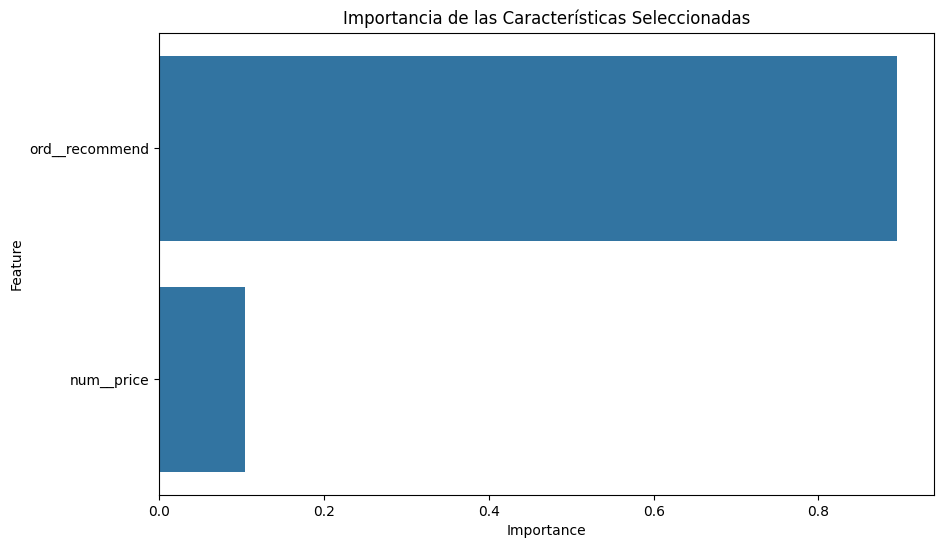

In [75]:
# Obtener la importancia de las características seleccionadas
feature_importance_selected = model.feature_importances_

# Crear un DataFrame con las características seleccionadas y su importancia
feature_importance_selected_df = pd.DataFrame({'Feature': selected_columns, 'Importance': feature_importance_selected})

# Ordenar por importancia descendente
feature_importance_selected_df = feature_importance_selected_df.sort_values(by='Importance', ascending=False)

# Visualizar las características seleccionadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_selected_df)
plt.title('Importancia de las Características Seleccionadas')
plt.show()

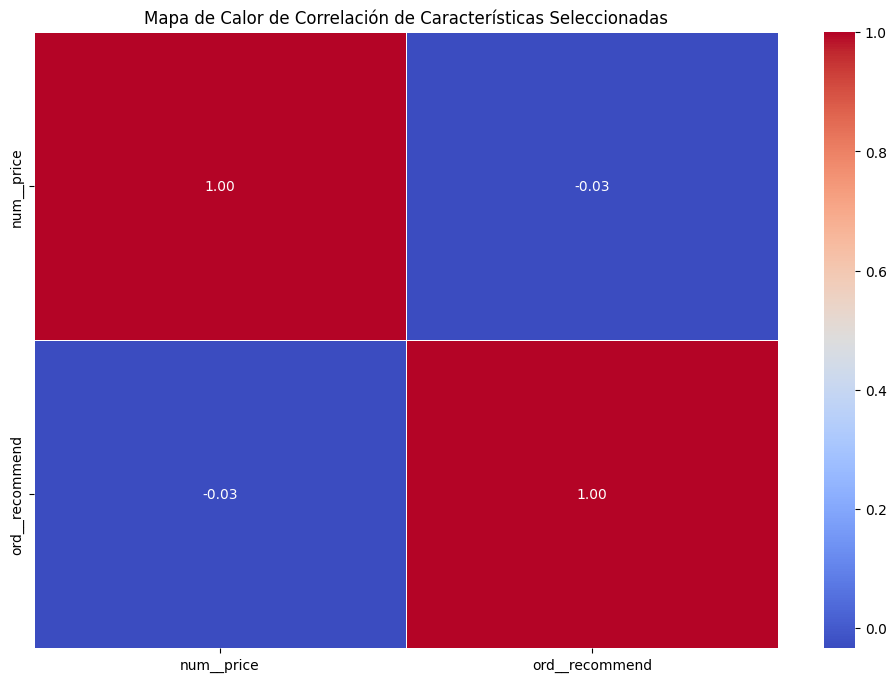

In [76]:
# Crear un DataFrame con las características seleccionadas
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns)

# Calcular la matriz de correlación
correlation_matrix = X_train_selected_df.corr()

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlación de Características Seleccionadas')
plt.show()